# Assignment 2

## First draft
### Youssef Ragab, Ting Huang, Garrett Hastings, Jaime Sarmiento


**1. Loading in the required libraries:**

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import h2o 
from h2o.estimators.gbm import H2OGradientBoostingEstimator 
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch 
from h2o.estimators.xgboost import H2OXGBoostEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator 
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.frame import H2OFrame      
import itertools       
import matplotlib.pyplot as plt        
import xgboost as xgb 
import time 
import seaborn as sns 
import numpy as np
import datetime
from interpret.glassbox import ExplainableBoostingClassifier
from interpret.perf import ROC

Initializations: 

In [3]:
Seed = 2021

nthreads = 4

h2o.init(max_mem_size= '6G', nthreads= nthreads)
h2o.remove_all()
h2o.no_progress()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_291"; Java(TM) SE Runtime Environment (build 1.8.0_291-b10); Java HotSpot(TM) 64-Bit Server VM (build 25.291-b10, mixed mode)
  Starting server from /Users/youssefragab/opt/miniconda3/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/23/tmpc6_652mqgzfhpdhdwtlz80000gn/T/tmpk8tzjasi
  JVM stdout: /var/folders/23/tmpc6_652mqgzfhpdhdwtlz80000gn/T/tmpk8tzjasi/h2o_youssefragab_started_from_python.out
  JVM stderr: /var/folders/23/tmpc6_652mqgzfhpdhdwtlz80000gn/T/tmpk8tzjasi/h2o_youssefragab_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Africa/Cairo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.3
H2O_cluster_version_age:,24 days
H2O_cluster_name:,H2O_from_python_youssefragab_s5ddok
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,5.333 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


Start global timer:

In [4]:
tic = time.time()

Importing data: 

In [5]:
train = pd.read_csv('hmda_train_preprocessed.csv')
test = pd.read_csv('hmda_test_preprocessed.csv')

In [6]:
train.columns

Index(['row_id', 'black', 'asian', 'white', 'amind', 'hipac', 'hispanic',
       'non_hispanic', 'male', 'female', 'agegte62', 'agelt62', 'term_360',
       'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std',
       'loan_to_value_ratio_std', 'no_intro_rate_period_std',
       'intro_rate_period_std', 'property_value_std', 'income_std',
       'debt_to_income_ratio_std', 'high_priced'],
      dtype='object')

In [7]:
test.columns

Index(['row_id', 'black', 'asian', 'white', 'amind', 'hipac', 'hispanic',
       'non_hispanic', 'male', 'female', 'agegte62', 'agelt62', 'term_360',
       'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std',
       'loan_to_value_ratio_std', 'no_intro_rate_period_std',
       'intro_rate_period_std', 'property_value_std', 'income_std',
       'debt_to_income_ratio_std'],
      dtype='object')

Now that we have the datasets loaded, we can proceed and remove the columns that we don't need from the training set. Based on the assignment prompt, we are going to keep the following variables:
* high_priced
* conforming 
* debt_to_income_ratio_std
* debt_to_income_ratio_missing
* income_std 
* loan_amount_std
* intro_rate_period_std
* loan_to_value_ratio_std
* no_intro_rate_period_std
* property_value_std
* term_360

In [8]:
x_name = ['conforming', 'debt_to_income_ratio_std', 'debt_to_income_ratio_missing', 'income_std', 'loan_amount_std', 'intro_rate_period_std', 'loan_to_value_ratio_std', 'no_intro_rate_period_std', 'property_value_std', 'term_360']
y_name = 'high_priced'

### Fitting interpretable models: 

**Splitting data into training and validation subsets:**

In [9]:
np.random.seed(Seed)

split_ratio = 0.7

split = np.random.rand(len(train)) < split_ratio

training = train[split]
validation = train[~split]

print('Train data rows = %d, columns = %d' % (training.shape[0], training.shape[1]))
print('Train data rows = %d, columns = %d' % (validation.shape[0], validation.shape[1])) 


Train data rows = 112085, columns = 23
Train data rows = 48253, columns = 23


### Elastic Net

**Defining wrapper function for hyperparameter grid search:**

In [10]:
def glm_grid(x_name, y_name, htrain, hvalid, seed):

    # Creating alpha options to set L2:
    alpha_options = [0.1, 0.25, 0.5, 0.99]
    
    # Defining serch criteria
    hyperparameters = {'alpha': alpha_options}

    # Initializing grid 
    grid = H2OGridSearch(
        H2OGeneralizedLinearEstimator(family = 'binomial',
                                      lambda_search = True,
                                      seed = seed),
        hyper_params = hyperparameters)

    # Executing training with grid search
    grid.train(y = y_name,
               x = x_name,
               training_frame = htrain, 
               validation_frame = hvalid,
               seed = seed)

    # Choosing the best model from the grid seach 
    best_model = grid.get_grid()[0]
    del grid 

    return best_model


**Fitting elastic net with grid search**

In [11]:
# Start timer 
glm_tic = time.time()

# Converting data into H2O Frame 
htrain = h2o.H2OFrame(training)
hvalid = h2o.H2OFrame(validation)

# Training with grid search 
best_glm = glm_grid(x_name, y_name, htrain, hvalid, Seed)

# End timer 
glm_toc = time.time() - glm_tic
print('Elastic net GLM training completed in %.2f s.' % glm_toc)

Elastic net GLM training completed in 11.96 s.


**Basic AUC assessment:**

In [12]:
print('Validation AUC: %.4f.' % best_glm.auc(valid = True))

Validation AUC: 0.7563.


**Score validation data with model**

In [13]:
best_glm_submit = best_glm.predict(h2o.H2OFrame(test)).as_data_frame()
best_glm_submit.drop(['predict', 'p0'], axis = 1, inplace = True)
best_glm_submit.columns = ['phat']
best_glm_submit = pd.concat([validation.reset_index(drop=True), best_glm_submit], axis=1)
best_glm_submit.head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat
0,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,-0.118642,0.268727,0.244394,-0.215304,-0.227585,-0.018133,-0.425131,0,0.143552
1,4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,0,-0.602338,0.552520,0.244394,-0.215304,-0.628437,-0.038228,0.763191,0,0.081619
2,7,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0,-0.734255,0.552520,0.244394,-0.215304,-0.720941,-0.039614,0.488963,0,0.128237
3,9,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,1.332446,-0.261719,0.244394,-0.215304,1.190815,0.075764,-1.156406,0,0.005958
4,12,1.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.024369,-0.425131,1,0.131587


#### Utility function for selecting percentiles

In [14]:
def get_percentile_dict(yhat_name, frame, id_):

    """ Returns the percentiles of a column, yhat_name, as the indices based on
        another column id_.
        :param yhat_name: Name of column in frame in which to find percentiles.
        :param frame: Pandas frame.
        :param id_: Validation Pandas frame containing yhat and id_.
        :return: Dictionary of percentile values and index column values.
    """

    # create a copy of frame and sort it by yhat
    sort_df = frame.copy(deep=True)
    sort_df.sort_values(yhat_name, inplace=True)
    sort_df.reset_index(inplace=True)

    # find top and bottom percentiles
    percentiles_dict = {0: sort_df.loc[0, id_], 99: sort_df.loc[sort_df.shape[0] - 1, id_]}

    # find 10th-90th percentiles
    inc = sort_df.shape[0] // 10
    for i in range(1, 10):
        percentiles_dict[i * 10] = sort_df.loc[i * inc, id_]

    return percentiles_dict

#### Select percentiles from predictions

In [15]:
best_glm_percentiles = get_percentile_dict('phat', best_glm_submit, 'row_id')
for key in sorted(best_glm_percentiles.keys()):
    print(str(key) + ': ' + str(best_glm_percentiles[key]))

0: 15340
10: 65757
20: 42634
30: 49003
40: 20879
50: 80111
60: 96502
70: 112762
80: 128906
90: 144457
99: 160335


#### Collect global feature importance info

In [16]:
# use coefficients as relative global feature importance
global_feat_imp = pd.DataFrame.from_dict(best_glm.coef(), columns=['GLM Importance'], orient='index')
global_feat_imp.drop('Intercept', inplace=True)
global_feat_imp['GLM Importance'] = np.abs(global_feat_imp['GLM Importance'])

In [17]:
global_feat_imp

,GLM Importance
term_360,0.222036
conforming,0.000000
debt_to_income_ratio_missing,0.000000
loan_amount_std,0.000000
loan_to_value_ratio_std,0.187109
no_intro_rate_period_std,0.000000
intro_rate_period_std,0.000000
property_value_std,0.982825
income_std,0.000000
debt_to_income_ratio_std,0.330614


#### Collect local feature importance info

In [18]:
# use (coefficient * value) as local feature importance

# init frame to store local contribs
local_fi_dict = {10: pd.DataFrame(columns = ['GLM Contribution'], index=x_name),
                 50: pd.DataFrame(columns = ['GLM Contribution'], index=x_name),
                 90: pd.DataFrame(columns = ['GLM Contribution'], index=x_name)}

# get (coefficient * value) at three percentiles of phat
for name in x_name:
    for percentile in [10, 50, 90]:
    
        # local contributions = beta_j * x_i,j
        local_fi_dict[percentile].loc[name, 'GLM Contribution'] =\
            best_glm.coef()[name] *\
            validation[validation['row_id'] == int(best_glm_percentiles[percentile])][name].values[0]

### Monotonic XGBoost
**Define utility function for random grid search**

In [19]:
def xgb_grid(dtrain, dvalid, mono_constraints=None, gs_params=None, n_models=None,
             ntree=None, early_stopping_rounds=None, verbose=False, seed=None):
    

    # cartesian product of gs_params
    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # preserve exact reproducibility for this function
    np.random.seed(Seed) 
    
    # select randomly from cartesian product space
    selected_experiments = np.random.choice(len(experiments), n_models)

    # set global params for objective,  etc.
    params = {'booster': 'gbtree',
              'eval_metric': 'auc',
              'nthread': nthreads,
              'objective': 'binary:logistic',
              'seed': Seed}

    # init grid search loop
    best_candidate = None
    best_score = 0

    # grid search loop
    for i, exp in enumerate(selected_experiments):

        params.update(experiments[exp])  # override global params with current grid run params

        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)

        # train on current params
        watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
        
        if mono_constraints is not None:
            params['monotone_constraints'] = mono_constraints
        
        candidate = xgb.train(params,
                              dtrain,
                              ntree,
                              early_stopping_rounds=early_stopping_rounds,
                              evals=watchlist,
                              verbose_eval=verbose)    

        # determine if current model is better than previous best
        if candidate.best_score > best_score:
            best_candidate = candidate
            best_score = candidate.best_score
            print('Grid search new best score discovered at iteration %d/%d: %.4f.' %
                             (int(i + 1), int(n_models), candidate.best_score))

        print('---------- ----------')
            
    return best_candidate

**Fit monotonic XGBoost with random grid search**

In [20]:
# dictionary of hyperparameter value lists for grid search
gs_params = {'colsample_bytree': [0.3, 0.5, 0.7, 0.9],
             'colsample_bylevel': [0.3, 0.5, 0.7, 0.9],
             'eta': [0.005, 0.05, 0.5],
             'max_depth': [3, 5, 7],
             'reg_alpha': [0.0005, 0.005, 0.05],
             'reg_lambda': [0.0005, 0.005, 0.05],
             'subsample': [0.3, 0.5, 0.7, 0.9],
             'min_child_weight': [1, 5, 10], 
             'gamma': [0.0, 0.1, 0.2 , 0.3, 0.4]}

# define monotonicity constraints
mono_constraints = tuple([int(i) for i in np.sign(train[x_name + [y_name]].corr()[y_name].values[:-1])])

# start local timer
mxgb_tic = time.time()

# Convert data to SVMLight format
dtrain = xgb.DMatrix(training[x_name], training[y_name])
dvalid = xgb.DMatrix(validation[x_name], validation[y_name])

# Monotonic XGBoost grid search
best_mxgb = xgb_grid(dtrain, dvalid, gs_params=gs_params, n_models=50, ntree=1000, early_stopping_rounds=100, 
                     mono_constraints=mono_constraints, seed=Seed)

# end local timer
mxgb_toc = time.time() - mxgb_tic
print('Monotonic GBM training completed in %.2f s.' % (mxgb_toc))

ee': 0.5, 'colsample_bylevel': 0.3, 'eta': 0.005, 'max_depth': 5, 'reg_alpha': 0.005, 'reg_lambda': 0.05, 'subsample': 0.7, 'min_child_weight': 5, 'gamma': 0.3, 'monotone_constraints': (1, 1, 1, -1, -1, -1, 1, 1, -1, 1)}
---------- ----------
Grid search run 4/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 2021, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'eta': 0.005, 'max_depth': 7, 'reg_alpha': 0.05, 'reg_lambda': 0.05, 'subsample': 0.7, 'min_child_weight': 10, 'gamma': 0.4, 'monotone_constraints': (1, 1, 1, -1, -1, -1, 1, 1, -1, 1)}
---------- ----------
Grid search run 5/50:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 2021, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.3, 'eta': 0.05, 'max_depth': 3, 'reg_alpha': 0.0005, 'reg_lambda': 0.005, 'subsample': 0.5, 'min_child_weight': 10, 'gamma': 0.4, 'monotone_constra

**Basic AUC assessment**

In [21]:
print('Validation AUC: %.4f.' % best_mxgb.best_score)

Validation AUC: 0.7913.


**Score validation data with model**

In [22]:
dtest = xgb.DMatrix(test[x_name])
best_mxgb_submit = pd.DataFrame(best_mxgb.predict(dtest, ntree_limit=best_mxgb.best_ntree_limit), columns=['phat'])
best_mxgb_submit = pd.concat([validation.reset_index(drop=True), best_mxgb_submit], axis=1)
best_mxgb_submit.head()

/Users/youssefragab/opt/miniconda3/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat
0,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,-0.118642,0.268727,0.244394,-0.215304,-0.227585,-0.018133,-0.425131,0,0.066171
1,4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,0,-0.602338,0.552520,0.244394,-0.215304,-0.628437,-0.038228,0.763191,0,0.034349
2,7,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0,-0.734255,0.552520,0.244394,-0.215304,-0.720941,-0.039614,0.488963,0,0.171695
3,9,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,1.332446,-0.261719,0.244394,-0.215304,1.190815,0.075764,-1.156406,0,0.031904
4,12,1.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.024369,-0.425131,1,0.176868


#### Select percentiles from predictions

In [23]:
best_mxgb_percentiles = get_percentile_dict('phat', best_mxgb_submit, 'row_id')
for key in sorted(best_mxgb_percentiles.keys()):
    print(str(key) + ': ' + str(best_mxgb_percentiles[key]))

0: 47749
10: 19337
20: 6113
30: 14451
40: 318
50: 80111
60: 96502
70: 112762
80: 128906
90: 144457
99: 160335


#### Calculate Shapley values

In [24]:
shapley_contribs = best_mxgb.predict(dvalid, pred_contribs=True, iteration_range=(0, best_mxgb.best_ntree_limit))

#### Collect global feature importance info

In [25]:
# use mean abs SHAP as feature importance
shapley_contribs_df = pd.DataFrame(shapley_contribs, columns=x_name + ['intercept'])
global_feat_imp['MXGB Importance'] = np.abs(shapley_contribs_df.drop('intercept', axis=1)).mean()

#### Collect local feature importance info

In [26]:
# create mapping between validation row_id and Shapely array index values
valid_idx_map = validation['row_id'].copy(deep=True)
valid_idx_map.reset_index(drop=True, inplace=True)

# collect SHAP values at three percentiles of phat
for percentile in [10, 50, 90]:

    # using valid_idx_map and percentiles dict
    # to find the right local contributions
    idx = valid_idx_map[valid_idx_map == int(best_mxgb_percentiles[percentile])].index[0]
    s_df = pd.DataFrame(shapley_contribs[idx, :-1].T, columns=['MXGB Contribution'], index=x_name)
    local_fi_dict[percentile]['MXGB Contribution'] = 0
    local_fi_dict[percentile].update(s_df)

**Calculate Random Forest Contributions:**

In [27]:
ebm_tic = time.time()

best_rf_contribs = rf_model1.explain_local(validation[x_name])
names = best_ebm_contribs._internal_obj['specific'][0]['names']
best_ebm_contribs_df = pd.DataFrame(columns=names)

 extract scores from insane _internal_obj
 new versions just have predict_and_explain() function
 use that if you can
for i in range(0, valid.shape[0]):
    row_df = pd.DataFrame(np.array(best_ebm_contribs._internal_obj['specific'][i]['scores']).reshape(1, 25), columns=names)
    best_ebm_contribs_df = best_ebm_contribs_df.append(row_df, ignore_index=True)
    del row_df
    
 end local timer
ebm_toc = time.time() - ebm_tic
print('EBM contributions collected in %.2f s.' % (ebm_toc))

### Explainable Boosting Model 


In [28]:
def ebm_grid(train, valid, x_names, y_name, gs_params=None, n_models=None, early_stopping_rounds=None, seed=None):
    
    # cartesian product of gs_params
    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # preserve exact reproducibility for this function
    np.random.seed(Seed) 
    
    # select randomly from cartesian product space
    selected_experiments = np.random.choice(len(experiments), n_models)

    # set global params for seed, etc.
    params = {'n_jobs': nthreads,
              'early_stopping_rounds': early_stopping_rounds, 
              'random_state': Seed}

    # init grid search loop
    best_candidate = None
    best_score = 0

    # grid search loop
    for i, exp in enumerate(selected_experiments):

        params.update(experiments[exp])  # override global params with current grid run params

        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)
        
        # train 
        ebm = ExplainableBoostingClassifier(**params)
        candidate = ebm.fit(train[x_names], train[y_name]) 
        
        # calculate AUC
        ebm_perf = ROC(ebm.predict_proba).explain_perf(valid[x_names], valid[y_name])
        candidate_best_score = ebm_perf._internal_obj['overall']['auc']
    
        # determine if current model is better than previous best
        if candidate_best_score > best_score:
            best_candidate = candidate
            best_score = candidate_best_score
            print('Grid search new best score discovered at iteration %d/%d: %.4f.' %
                             (int(i + 1), int(n_models), candidate_best_score))

        print('---------- ----------')
        
        del ebm
            
    return best_candidate

In [29]:
# dictionary of hyperparameter value lists for grid search
gs_params = {'max_bins': [128, 256, 512],
             'max_interaction_bins': [16, 32, 64],
             'interactions': [5, 10, 15],
             'outer_bags': [4, 8, 12], 
             'inner_bags': [0, 4],
             'learning_rate': [0.001, 0.01, 0.05],
             'validation_size': [0.1, 0.25, 0.5],
             'min_samples_leaf': [1, 2, 5, 10],
             'max_leaves': [1, 3, 5]}

# start local timer
ebm_tic = time.time()

# EBM grid search
best_ebm = ebm_grid(training, validation, x_name, y_name, gs_params=gs_params, n_models=10, 
                    early_stopping_rounds=100, seed=Seed)

# end local timer
ebm_toc = time.time() - ebm_tic
print('EBM training completed in %.2f s.' % (ebm_toc))

Grid search run 1/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 2021, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 5, 'outer_bags': 8, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.1, 'min_samples_leaf': 10, 'max_leaves': 1}
Grid search new best score discovered at iteration 1/10: 0.8145.
---------- ----------
Grid search run 2/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 2021, 'max_bins': 128, 'max_interaction_bins': 32, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 0, 'learning_rate': 0.05, 'validation_size': 0.1, 'min_samples_leaf': 2, 'max_leaves': 5}
Grid search new best score discovered at iteration 2/10: 0.8239.
---------- ----------
Grid search run 3/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 2021, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 10, 'outer_bags': 4, 'inner_bags': 4, 'learning_rat

#### Basic AUC assessment 

In [30]:
best_ebm_perf = ROC(best_ebm.predict_proba).explain_perf(validation[x_name], validation[y_name])
print('Validation AUC: %.4f.' % best_ebm_perf._internal_obj['overall']['auc'])

Validation AUC: 0.8239.


**Score validation data with model**

In [31]:
best_ebm_phat = pd.DataFrame(best_ebm.predict_proba(validation[x_name])[:, 1], columns=['phat']) 
best_ebm_phat = pd.concat([validation.reset_index(drop=True), best_ebm_phat], axis=1)
best_ebm_phat.head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat
0,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,-0.118642,0.268727,0.244394,-0.215304,-0.227585,-0.018133,-0.425131,0,0.042698
1,4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,0,-0.602338,0.552520,0.244394,-0.215304,-0.628437,-0.038228,0.763191,0,0.236607
2,7,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0,-0.734255,0.552520,0.244394,-0.215304,-0.720941,-0.039614,0.488963,0,0.289141
3,9,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,1.332446,-0.261719,0.244394,-0.215304,1.190815,0.075764,-1.156406,0,0.001697
4,12,1.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.024369,-0.425131,1,0.168496


**Select percentiles from predictions**

In [32]:
best_ebm_percentiles = get_percentile_dict('phat', best_ebm_phat, 'row_id')
for key in sorted(best_ebm_percentiles.keys()):
    print(str(key) + ': ' + str(best_ebm_percentiles[key]))

0: 27655
10: 119646
20: 92761
30: 122476
40: 67573
50: 72822
60: 72159
70: 154423
80: 62937
90: 7289
99: 48124


**Calculate EBM contributions**

In [33]:
# start local timer
ebm_tic = time.time()

# EBM feature scores as local importance
# mean abs score as global importance
best_ebm_contribs = best_ebm.explain_local(validation[x_name])
names = best_ebm_contribs._internal_obj['specific'][0]['names']
best_ebm_contribs_df = pd.DataFrame(columns=names)


for i in range(0, validation.shape[0]):
    row_df = pd.DataFrame(np.array(best_ebm_contribs._internal_obj['specific'][i]['scores']).reshape(1, 20), columns=names)
    best_ebm_contribs_df = best_ebm_contribs_df.append(row_df, ignore_index=True)
    del row_df
    
# end local timer
ebm_toc = time.time() - ebm_tic
print('EBM contributions collected in %.2f s.' % (ebm_toc))


EBM contributions collected in 57.36 s.


**Collect global feature importance info**

In [34]:
global_feat_imp['EBM Importance'] = np.abs(best_ebm_contribs_df).mean()

**Collect local feature importance info**

In [35]:
# extract scores at three percentiles of phat
for percentile in [10, 50, 90]:
 
    # using valid_idx_map and percentiles dict
    # to find the right local contributions
    idx = valid_idx_map[valid_idx_map == int(best_ebm_percentiles[percentile])].index[0]
    s_df = best_ebm_contribs_df.iloc[idx, :len(x_name)].T
    s_df.columns = ['EBM Contribution']
    local_fi_dict[percentile]['EBM Contribution'] = s_df

## Analyze feature importance

#### Compare global feature importance across models

/Users/youssefragab/opt/miniconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


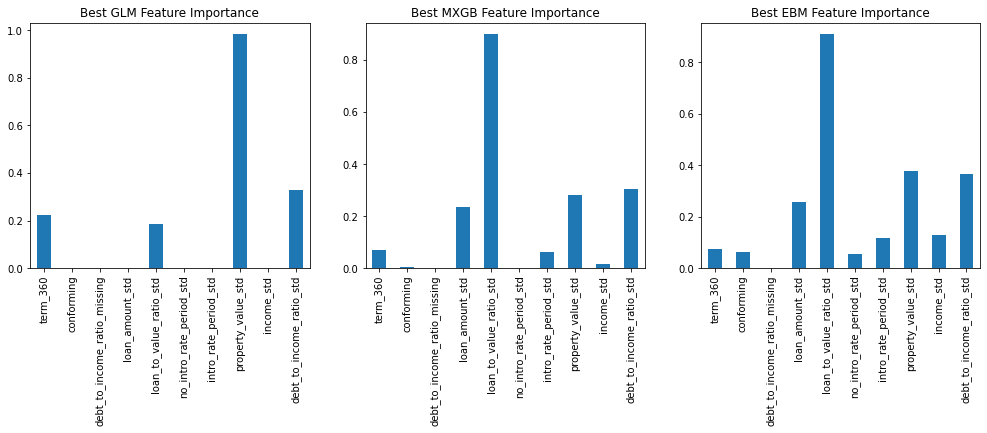

In [36]:
# init 3-pane plot 
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3)
plt.tight_layout()
plt.subplots_adjust(left=0, right=2.2, wspace=0.2)

# plot global FI across three panes
_ = global_feat_imp['GLM Importance'].plot(kind='bar', ax=ax0, title='Best GLM Feature Importance')
_ = global_feat_imp['MXGB Importance'].plot(kind='bar', ax=ax1, title='Best MXGB Feature Importance')
_ = global_feat_imp['EBM Importance'].plot(kind='bar', ax=ax2, title='Best EBM Feature Importance')

#### Compare local feature importance across models

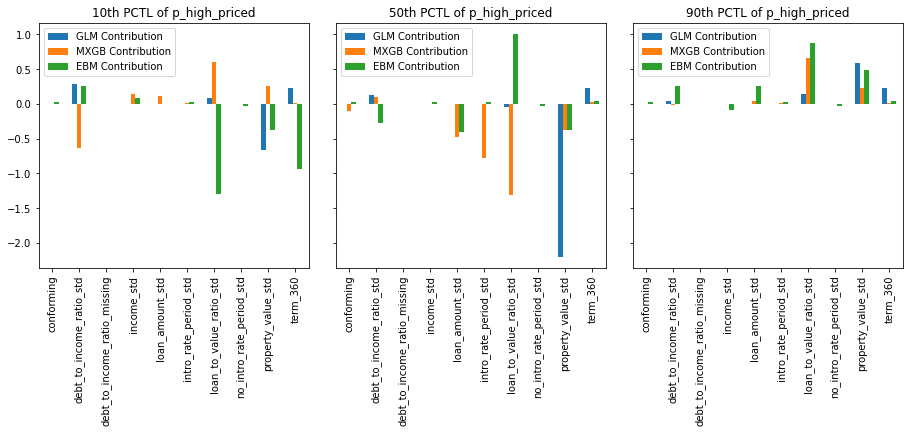

In [37]:
## init 3-pane plot 
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, sharey=True)
plt.tight_layout()
plt.subplots_adjust(left=0, right=2, wspace=0.1)

# plot comparisons of local FI across 3 panes
_ = local_fi_dict[10].plot(kind='bar', ax=ax0,
                             title='10th PCTL of p_high_priced')

_ = local_fi_dict[50].plot(kind='bar', ax=ax1,
                             title='50th PCTL of p_high_priced')

_ = local_fi_dict[90].plot(kind='bar', ax=ax2,
                             title='90th PCTL of p_high_priced')

#### Utility function for partial dependence

In [38]:
def par_dep(x_name, valid, model, model_type, resolution=20, bins=None):

    """ Creates Pandas DataFrame containing partial dependence or ICE
        for a single input variable.
        :param x_name: Variable for which to calculate partial dependence.
        :param valid: Pandas validation frame.
        :param model: Trained model object (assumes binary classifier).
        :param model_type: Kind of model: h2o, xgb, or ebm.
        :param resolution: The number of points across the domain of xs for which
                           to calculate partial dependence, default 20.
        :param bins: List of values at which to set xs, default 20 equally-spaced
                     points between column minimum and maximum.
        :return: Pandas DataFrame containing partial dependence values.
    """

    # turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None

    # determine values at which to calculate partial dependence
    if bins is None:
        min_ = valid[x_name].min()
        max_ = valid[x_name].max()
        by = (max_ - min_) / resolution
        # modify max and by
        # to preserve resolution and actually search up to max
        bins = np.arange(min_, (max_ + by), (by + np.round((1. / resolution) * by, 3)))
        
    # cache original column values
    col_cache = valid.loc[:, x_name].copy(deep=True)

    # calculate partial dependence
    # by setting column of interest to constant
    # and scoring the altered data and taking the mean of the predictions
    temp_df = valid.copy(deep=True)
    temp_df.loc[:, x_name] = bins[0]
    for j, _ in enumerate(bins):
        if j + 1 < len(bins):
            valid.loc[:, x_name] = bins[j + 1]
            temp_df = temp_df.append(valid, ignore_index=True)

    # return input frame to original cached state
    valid.loc[:, x_name] = col_cache

    # model predictions
    # probably assumes binary classification
    if model_type == 'h2o':
        temp_df['partial_dependence'] = model.predict(h2o.H2OFrame(temp_df))['p1'].as_data_frame()
    if model_type == 'xgb':
        temp_df['partial_dependence'] = pd.DataFrame(model.predict(xgb.DMatrix(temp_df), iteration_range=(0, best_mxgb.best_ntree_limit)), columns=['phat'])
    if model_type == 'ebm':
        temp_df['partial_dependence'] = pd.DataFrame(model.predict_proba(temp_df)[:, 1], columns=['phat'])
    
    return pd.DataFrame(temp_df[[x_name, 'partial_dependence']].groupby([x_name]).mean()).reset_index()

#### Calculate partial dependence for all X and models

In [39]:
# start local timer
pd_tic = time.time()

# init dict to hold results
pd_dict = {}

# cycle through names and model types to calculate par dep
for name in x_name:
    
    print('Calculating partial dependence for %s ...' % name)
    
    # setup a dataframe to hold results
    # use bins from first par_dep() run
    pd_dict[name] = pd.DataFrame(columns=[name, 'h2o', 'xgb', 'ebm'])
    first_pd = par_dep(name, validation[x_name], best_glm, 'h2o')
    pd_dict[name][name] = first_pd[name]
    bins = first_pd[name]
    pd_dict[name]['h2o'] = first_pd['partial_dependence']
    
    # calculate par dep for remaining models
    pd_dict[name]['xgb'] = par_dep(name, validation[x_name], best_mxgb, 'xgb', bins=bins)['partial_dependence']
    pd_dict[name]['ebm'] = par_dep(name, validation[x_name], best_ebm, 'ebm', bins=bins)['partial_dependence']
    
print('Done.')

# end local timer
pd_toc = time.time() - pd_tic
print('Partial dependence calculated in %.2f s.' % (pd_toc))

Calculating partial dependence for conforming ...
Calculating partial dependence for debt_to_income_ratio_std ...
Calculating partial dependence for debt_to_income_ratio_missing ...
Calculating partial dependence for income_std ...
Calculating partial dependence for loan_amount_std ...
Calculating partial dependence for intro_rate_period_std ...
Calculating partial dependence for loan_to_value_ratio_std ...
Calculating partial dependence for no_intro_rate_period_std ...
Calculating partial dependence for property_value_std ...
Calculating partial dependence for term_360 ...
Done.
Partial dependence calculated in 225.32 s.


#### Plot partial dependence for all features and models

/Users/youssefragab/opt/miniconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/Users/youssefragab/opt/miniconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/Users/youssefragab/opt/miniconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/Users/youssefragab/opt/miniconda3/lib/python3.8/site-pack

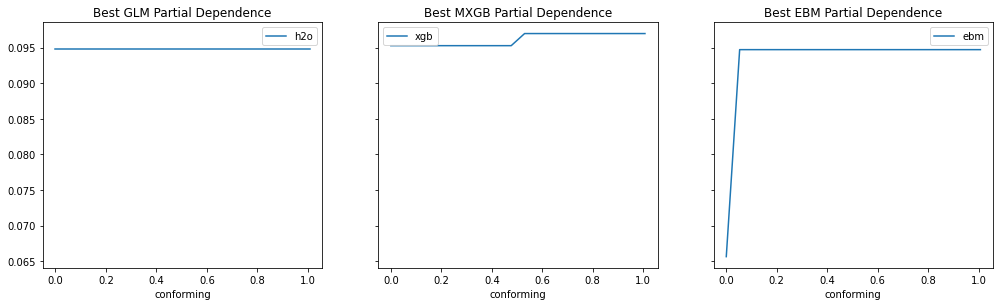

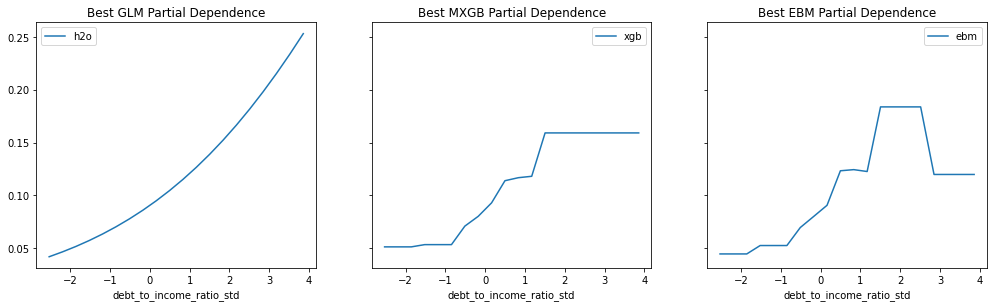

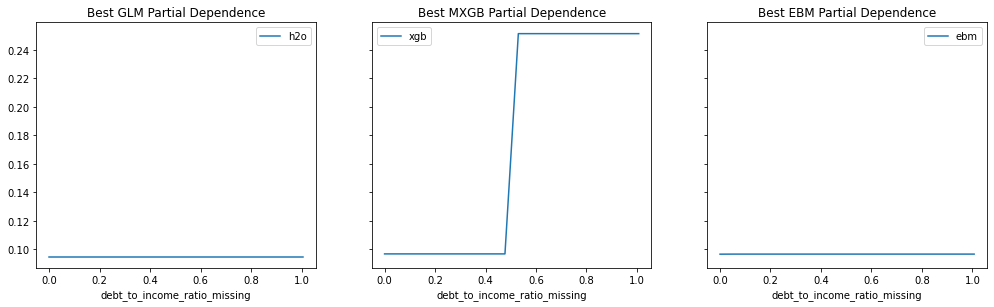

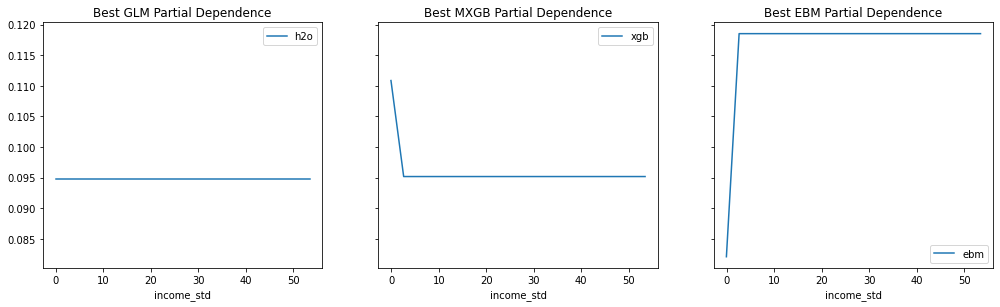

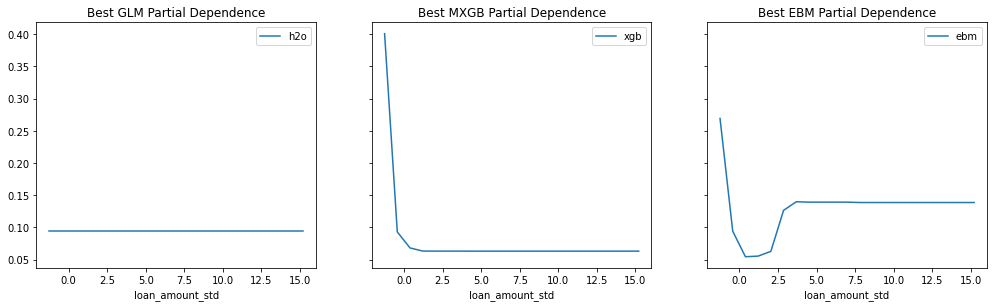

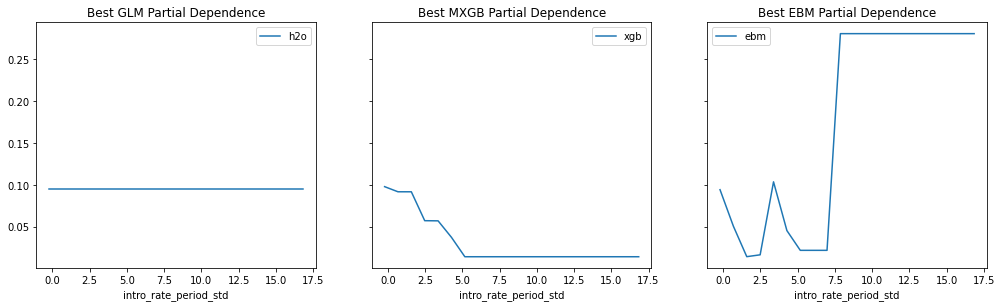

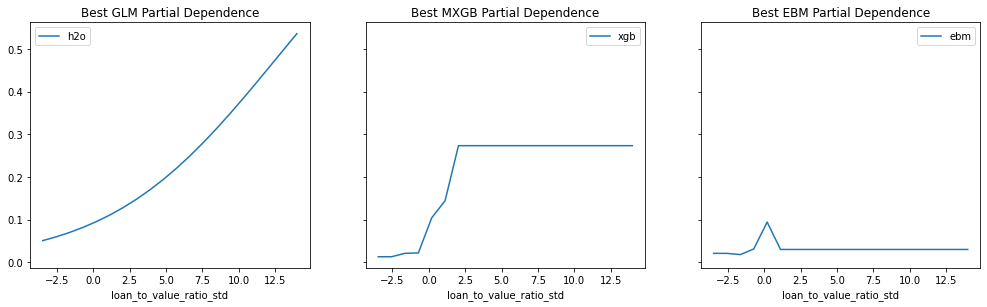

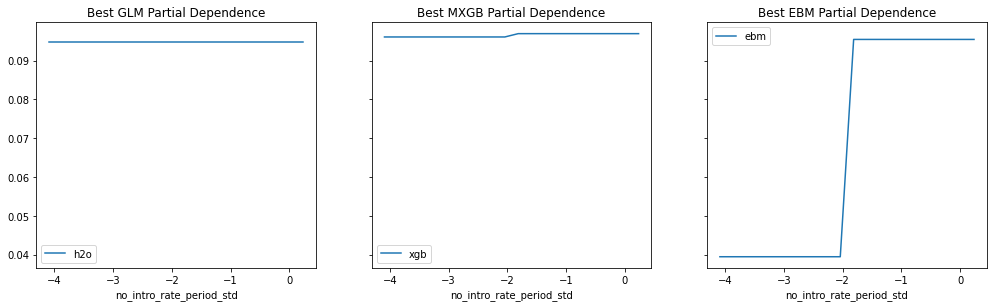

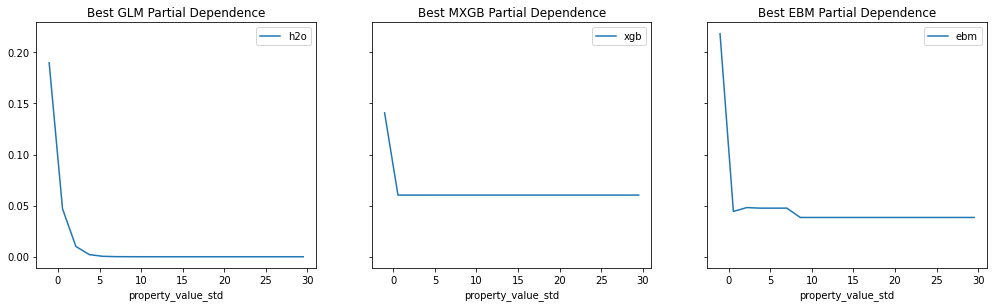

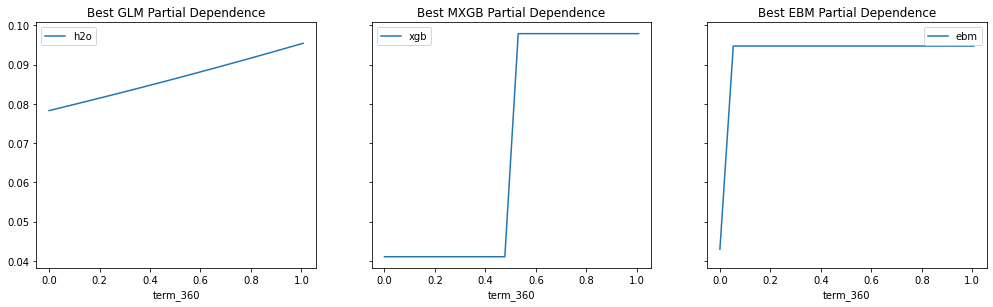

In [40]:
# loop through names to calculate par dep 
for name in x_name:
    
    # init 3-pane plot
    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, sharey=True)
    plt.tight_layout()
    plt.subplots_adjust(left=0, right=2.2, wspace=0.2)
  
    # plot par dep from each model across frames
    pd_dict[name].plot(kind='line', x=name, y='h2o', ax=ax0, title='Best GLM Partial Dependence')
    ax0.set_xlabel(name)
    pd_dict[name].plot(kind='line', x=name, y='xgb', ax=ax1, title='Best MXGB Partial Dependence') 
    ax1.set_xlabel(name)
    pd_dict[name].plot(kind='line', x=name, y='ebm', ax=ax2, title='Best EBM Partial Dependence')
    ax2.set_xlabel(name)

#### End timer

In [41]:
toc = time.time() - tic
print('All tasks completed in %.2f s.' % (toc))

All tasks completed in 1407.06 s.


#### Shut down h2o

In [42]:
h2o.cluster().shutdown(prompt=False)

H2O session _sid_8cc6 closed.
